# Implementation of Knowledge Based SDDC LCM. 

#### Proposing a Knowledge Based Life Cycle Management method for the Infrastructure Components and the Applications in the Scaled Hyper Converged Software Defined Data Centers is a project to manage life cycle Management (LCM) software which will look for “Best Window time” or “best time” to perform Life Cycle Management.  So that the Administrator can perform LCM whenever upgrade or patch is available for any entity (Application or Infrastructure component) .  This will help avoid any risk because of ongoing  upgrades or patches 

### Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time
from time import strftime
from utils import util


### configure spark variables 

In [2]:
__author__ = 'raviranjan'

#from pyspark import SparkConf, SparkContext
#from pyspark.context import SparkContext
#from pyspark.sql.context import SQLContext
#from pyspark.sql.session import SparkSession
   
#sc = SparkContext()
#sqlContext = SQLContext(sc)
#spark = SparkSession(sc)

### Define variables contants

In [3]:
LOG_DIR = "logs"
TIME_STAMP_PATTERN = "^(2[0-3]|[01]?[0-9]):(0[1-9]{1}|[1-5]{1}[0-9]):(0[1-9]{1}|[1-5]{1}[0-9])$"
HOST_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
LOGGER_FILE_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
ERROR_PATTERN = 'ERROR:'
INFO_PATTERN = 'INFO:'
DEBUG_PATTERN = 'DEBUG:'
time_stamp_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
logger_file_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
has_error_pattern = r''
excel_file_path = "data/excel_data_1.xlsx"



# Create a util class

In [4]:
import re
import os
import time
from time import strftime


def export_to_file(dict_with_list_values=None, export_file_path=None, export_folder=None):
    """
    dict_with_list_values = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [32000,35000,37000,45000]
        }
    :param export_folder:
    :param dict_with_list_values:
    :param create_dict_from_list:
    :param column_name
    :return:
    """
    if not export_file_path:
        time_now = str(strftime("%Y-%m-%d %H-%M-%S", time.localtime()))
        export_file_path = export_folder + "/" + time_now + ".xlsx"
    columns = dict_with_list_values.keys()
    print('Exporting columns %s to %s' % (columns, export_file_path))
    import pandas as pd
    df = pd.DataFrame(dict_with_list_values, columns=columns)
    df.to_excel(export_file_path, index=False, header=True)
    print(export_file_path)
    return export_file_path


def get_data_to_export(log_files, column_names=['timestamp', 'info', 'error', 'debug', 'warn', 'exception', 'filename', 'line'], add_time_stamp=True):
    excel_export_data = {
    }
    for column_name in column_names:
        excel_export_data[column_name] = []
    print("Define column %s" % excel_export_data)
    for log_file in log_files:
        with open(log_file) as f:
            for line in f:
                one_row_values = {} # store one row value with key as column name and its value
                for column_name in column_names:
                    column_name = column_name.lower()
                    line = line.lower().strip()
                    if column_name in line:
                        cell_value = 1
                    else:
                        cell_value = 0
                    if column_name == "line":
                        cell_value = line
                    if column_name == "filename":
                        cell_value = log_file.split('/')[-1]
                    if add_time_stamp and column_name == "timestamp":
                        RE_COMPILE_TIME_STAMP_PATTERN = "(24:00|2[0-3]:[0-5][0-9]|[0-1][0-9]:[0-5][0-9]:[0-5][0-9])"
                        cell_value = finditer_line(line, regex=RE_COMPILE_TIME_STAMP_PATTERN)

                    # Final cell value for that column
                    one_row_values[column_name] = cell_value

                for column_name in one_row_values:
                    # append the list value
                    existing_one_column_values = excel_export_data[column_name]
                    existing_one_column_values.append(one_row_values[column_name])
                    excel_export_data[column_name] = existing_one_column_values
    files = []
    for log_file in log_files:
        log_file = log_file.split('/')[-1]
        files.append(log_file)
    for column_name in column_names:
        print("Total %s values for Column:%s in all log files" % (len(excel_export_data[column_name]), column_name))

    return excel_export_data


def get_log_files(log_dir):
    log_files = []
    for root, dir_, files in os.walk(log_dir):
        for sub_dir in dir_:
            sub_dir_path = os.path.join(root, sub_dir)
            # print("sub_dir: %s" % sub_dir_path)
            # os.system('ls %s' % sub_dir_path)
        for f in files:
            f_path = os.path.join(root, f)
            if ".log" in f_path:
                log_files.append(f_path)
    print("%s" % (log_files))
    return log_files


def findall_(log_file, regex):
    matched_lines = []
    with open(log_file) as f:
        # lines = f.readlines()
        for line in f:
            found = re.findall(regex, line)
            if found:
                matched_lines.append(line)
        print(matched_lines)
    return matched_lines


def search_re(line, pattern=None):
    # Python program to illustrate
    # Matching regex objects
    match = re.match(pattern, line)
    if not match:
        regex_com = re.compile(pattern)
        match = regex_com.search(line)
        if match:
            value = match.group()
            print('found using re.compile: %s' % value)
            return value
        else:
            print('%s not Found using re.compile also:' % pattern)
            return ''
    else:
        value = match.group()
        print('Found using re.match: %s' % value)
        return value


def finditer_(log_file_path, regex, read_line=True):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    with open(log_file_path, "r") as f:
        match_list = []
        if read_line:
            for line in f:
                for match in re.finditer(regex, line, re.S):
                    match_text = match.group()
                    match_list.append(match_text)
        else:
            data = f.read()
            for match in re.finditer(regex, data, re.S):
                match_text = match.group()
                match_list.append(match_text)
    f.close()
    print(match_list)
    return match_list


def finditer_line(line, regex):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    match_text = 'time Not Found'
    for match in re.finditer(regex, line, re.S):
        match_text = match.group()
    return match_text


### Get log files

In [5]:
log_files = get_log_files(log_dir=LOG_DIR)

['logs/HealthApp/HealthApp.log', 'logs/OpenStack/OpenStack.log', 'logs/OpenSSH/SSH.log', 'logs/Proxifier/Proxifier.log', 'logs/HPC/HPC.log', 'logs/Zookeeper/Zookeeper.log', 'logs/Mac/Mac.log', 'logs/Hadoop/Hadoop.log', 'logs/Linux/Linux.log', 'logs/Andriod/Andriod.log', 'logs/HDFS/HDFS.log', 'logs/BGL/BGL.log', 'logs/Windows/Windows.log', 'logs/Apache/Apache.log', 'logs/Thunderbird/Thunderbird.log', 'logs/Spark/Spark.log']


### Get Data from logs and export to Excel 

In [6]:
excel_export_data = get_data_to_export(log_files=log_files, column_names=['timestamp', 'info', 'error', 'debug', 'warn', 'exception', 'filename', 'line'])

Define column {'timestamp': [], 'info': [], 'error': [], 'debug': [], 'warn': [], 'exception': [], 'filename': [], 'line': []}
Total 32000 values for Column:timestamp in all log files
Total 32000 values for Column:info in all log files
Total 32000 values for Column:error in all log files
Total 32000 values for Column:debug in all log files
Total 32000 values for Column:warn in all log files
Total 32000 values for Column:exception in all log files
Total 32000 values for Column:filename in all log files
Total 32000 values for Column:line in all log files


In [17]:
#export_to_file(dict_with_list_values=excel_export_data, export_file_path=excel_file_path)

# Analyzing Data

In [18]:
print(excel_file_path)
excel_data = pd.read_excel(excel_file_path)
excel_data.head(5)

data/excel_data_1.xlsx


,timestamp,info,error,debug,warn,exception,filename,line
0,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:606|step_lsc|30002312|onstan...
1,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:615|step_lsc|30002312|onexte...
2,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:633|step_standreportreceiver...
3,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_lsc|30002312|proces...
4,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_standstepcounter|30...


### Draw few plot


In [19]:
print((excel_data.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  32000 non-null  object
 1   info       32000 non-null  int64 
 2   error      32000 non-null  int64 
 3   debug      32000 non-null  int64 
 4   warn       32000 non-null  int64 
 5   exception  32000 non-null  int64 
 6   filename   32000 non-null  object
 7   line       32000 non-null  object
dtypes: int64(5), object(3)
memory usage: 2.0+ MB
None


<AxesSubplot:xlabel='error', ylabel='count'>

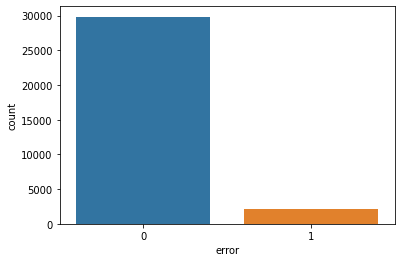

In [20]:
# how many rows having error value
sns.countplot(x="error", data=excel_data)

<AxesSubplot:xlabel='exception', ylabel='count'>

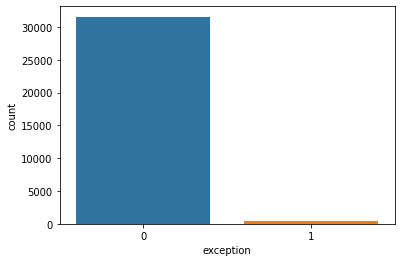

In [21]:
# how many rows having exception value
sns.countplot(x="exception", data=excel_data)

<AxesSubplot:xlabel='warn', ylabel='count'>

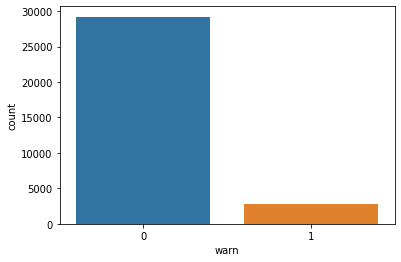

In [22]:
# how many rows having warn value
sns.countplot(x="warn", data=excel_data)

### Draw histogram 

<AxesSubplot:ylabel='Frequency'>

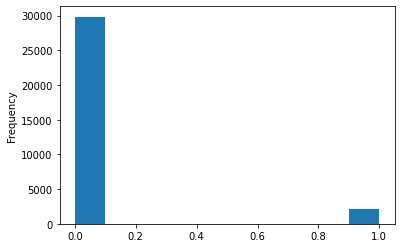

In [23]:
excel_data['error'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

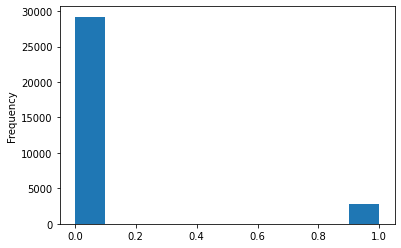

In [24]:
excel_data['warn'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

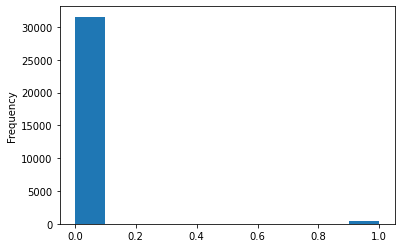

In [25]:
excel_data['exception'].plot.hist()

#  Data Wrangling


## Data Wrangling is to remove null or empty data, cleaning data set

In [26]:
print((excel_data.info()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  32000 non-null  object
 1   info       32000 non-null  int64 
 2   error      32000 non-null  int64 
 3   debug      32000 non-null  int64 
 4   warn       32000 non-null  int64 
 5   exception  32000 non-null  int64 
 6   filename   32000 non-null  object
 7   line       32000 non-null  object
dtypes: int64(5), object(3)
memory usage: 2.0+ MB
None


In [27]:
excel_data.isnull()


,timestamp,info,error,debug,warn,exception,filename,line
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
31995,False,False,False,False,False,False,False,False
31996,False,False,False,False,False,False,False,False
31997,False,False,False,False,False,False,False,False
31998,False,False,False,False,False,False,False,False


In [28]:
excel_data.isnull().sum()


timestamp    0
info         0
error        0
debug        0
warn         0
exception    0
filename     0
line         0
dtype: int64

In [29]:
#sns.heatmap(excel_data.isnull(), yticklabels==False)


<AxesSubplot:>

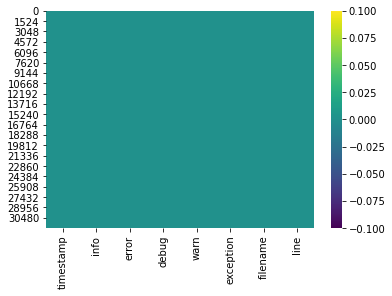

In [30]:
sns.heatmap(excel_data.isnull(), cmap="viridis")


<AxesSubplot:xlabel='error', ylabel='exception'>

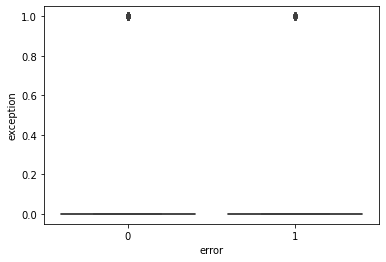

In [33]:
sns.boxplot(x="error", y="exception", data=excel_data)


In [41]:
# either drop that row or fill some value where value is null
excel_data.head(5)
excel_data.isnull().sum()


line         0
info         0
error        0
debug        0
warn         0
exception    0
filename     0
dtype: int64

<AxesSubplot:>

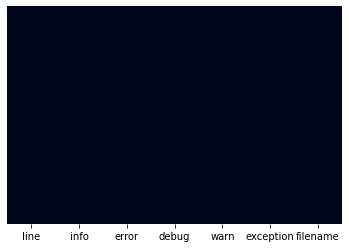

In [42]:
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


<AxesSubplot:>

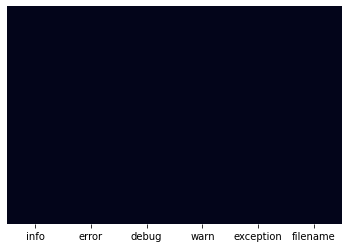

In [43]:
excel_data.drop("line", axis=1, inplace=True)
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


In [44]:
excel_data.isnull().sum()


info         0
error        0
debug        0
warn         0
exception    0
filename     0
dtype: int64

### hold column values in variable


In [47]:
info=pd.get_dummies(excel_data['info'])

In [48]:
excel_data = pd.concat([excel_data, info], axis=1)
excel_data.head(5)


,info,error,debug,warn,exception,filename,0,1,0,1
0,0,0,0,0,0,HealthApp.log,1,0,1,0
1,0,0,0,0,0,HealthApp.log,1,0,1,0
2,0,0,0,0,0,HealthApp.log,1,0,1,0
3,0,0,0,0,0,HealthApp.log,1,0,1,0
4,0,0,0,0,0,HealthApp.log,1,0,1,0


In [49]:
excel_data.drop(['info'], axis=True, inplace=True)
excel_data.head(5)

,error,debug,warn,exception,filename,0,1,0,1
0,0,0,0,0,HealthApp.log,1,0,1,0
1,0,0,0,0,HealthApp.log,1,0,1,0
2,0,0,0,0,HealthApp.log,1,0,1,0
3,0,0,0,0,HealthApp.log,1,0,1,0
4,0,0,0,0,HealthApp.log,1,0,1,0


In [56]:
excel_data.drop("filename", axis=1, inplace=True)
excel_data.head(5)

,error,debug,warn,exception,0,1,0,1
0,0,0,0,0,1,0,1,0
1,0,0,0,0,1,0,1,0
2,0,0,0,0,1,0,1,0
3,0,0,0,0,1,0,1,0
4,0,0,0,0,1,0,1,0


#  Train and Test

In [57]:
X = excel_data.drop("error", axis=1)
y = excel_data["error"]

In [58]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [60]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

In [61]:
logmodel.fit(X_train, y_train)


LogisticRegression()

In [62]:
predictions = logmodel.predict(X_test)

In [63]:
from sklearn.metrics import classification_report
classification_report(y_test, predictions)


/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

'              precision    recall  f1-score   support\n\n           0       0.93      1.00      0.97      9870\n           1       0.00      0.00      0.00       690\n\n    accuracy                           0.93     10560\n   macro avg       0.47      0.50      0.48     10560\nweighted avg       0.87      0.93      0.90     10560\n'

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


array([[9870,    0],
       [ 690,    0]])

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)


0.9346590909090909

#  Collecting Data


# Accuracy Check
